In [1]:
import numpy as np
import pandas as pd
from sklearn import model_selection, metrics, linear_model
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from pypredictbandgaps.material import Material
from pypredictbandgaps.bandgappredictions import BandGapPredictions
import pymatgen as mg
from pymatgen.ext.matproj import MPRester
mpr = MPRester()

Connection established to Materials Project database, version 2020_09_08.
Connection established to Materials Project database, version 2020_09_08.


In [2]:
def get_info(inp):
    properties = ["material_id","band_gap","spacegroup","unit_cell_formula"]
    results = mpr.query(criteria=inp,properties=properties)
    band_gaps = [ result["band_gap"] for result in results if result["band_gap"] ]
    return results, band_gaps

In [3]:
Si_res, Si_band_gaps = get_info("Si")
Ge_res, Ge_band_gaps = get_info("Ge")

In [4]:
print(f"""Training Average Band gaps:
Si: {np.average(Si_band_gaps)} eV
Ge: {np.average(Ge_band_gaps)} eV """)

Training Average Band gaps:
Si: 0.7591789473684211 eV
Ge: 0.6050250000000001 eV 


In [5]:
Si2Ge3 = Material(formula="Si2Ge3",spacegroup="F-43m",a=4.12,b=4.12,c=4.12,alpha=59.99,beta=59.99,gamma=59.99)#,volume=48) 
Si82Ge17 = Material(formula="Si82Ge17",spacegroup="F-43m",a=3.98,b=3.98,c=3.98,alpha=59.99,beta=59.99,gamma=59.99)#,volume=44) 
materials_list = [Si2Ge3,Si82Ge17]

### Ridge Regression

In [6]:
band_gap_predictions = BandGapPredictions(materials_list,model_type="ridge_regression")
band_gap_prediction_objects = band_gap_predictions.band_gap_prediction_objects


Starting prediciton for Si2Ge3 using ridge_regression model type...
Material training params: ['a', 'b', 'c', 'alpha', 'beta', 'gamma', 'Si', 'Ge']
Getting Materials Project data ...
Number of Ge-Si system entries in Materials Project: 6
Number of Si entries in Materials Project: 39
Number of Ge entries in Materials Project: 17
Number of results for training: 62


C:\Users\emily\Anaconda3\lib\site-packages\pymatgen\io\cif.py:1123: UserWarning: Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: %s" % "\n".join(self.warnings))


Training the model...
training params= ['a', 'b', 'c', 'alpha', 'beta', 'gamma', 'Si', 'Ge']


C:\Users\emily\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


ridge regression alpha_choice = 10.0
Making predictions...
predicted bandgap for  Si2Ge3 : 0.14512800224603423

Starting prediciton for Si82Ge17 using ridge_regression model type...
Material training params: ['a', 'b', 'c', 'alpha', 'beta', 'gamma', 'Si', 'Ge']
Getting Materials Project data ...
Number of Ge-Si system entries in Materials Project: 6
Number of Si entries in Materials Project: 39
Number of Ge entries in Materials Project: 17
Number of results for training: 62


C:\Users\emily\Anaconda3\lib\site-packages\pymatgen\io\cif.py:1123: UserWarning: Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: %s" % "\n".join(self.warnings))


Training the model...
training params= ['a', 'b', 'c', 'alpha', 'beta', 'gamma', 'Si', 'Ge']


C:\Users\emily\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


ridge regression alpha_choice = 10.0
Making predictions...
predicted bandgap for  Si82Ge17 : 0.07850939819429834


In [7]:
#model score: {band_gap_prediction_object.model_score}
for material, band_gap_prediction_object in band_gap_prediction_objects.items():
    x = band_gap_prediction_object.X_train
    y = band_gap_prediction_object.y_train
    band_gap = band_gap_prediction_object.predicted_band_gap
    score = band_gap_prediction_object.model.score(x,y)
    print(f""" 
    {material}
    -----------
    R-squared: {score}
    band gap: {band_gap} eV""")

 
    Si2Ge3
    -----------
    R-squared: 0.18690621938811214
    band gap: 0.14512800224603423 eV
 
    Si82Ge17
    -----------
    R-squared: 0.23796775923230473
    band gap: 0.07850939819429834 eV


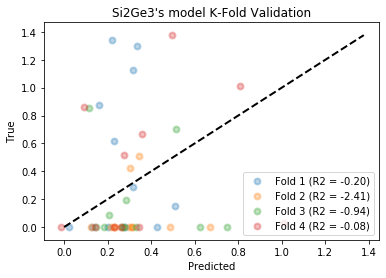

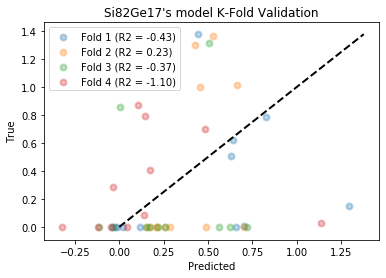

In [8]:
# K fold validation
# https://towardsdatascience.com/machine-learning-with-python-regression-complete-tutorial-47268e546cea
for material, band_gap_prediction_object in band_gap_prediction_objects.items():
    scores = list()
    cv = model_selection.KFold(n_splits=4, shuffle=True)
    fig = plt.figure()
    i = 1

    X_train = band_gap_prediction_object.X_train
    y_train = band_gap_prediction_object.y_train
    model = band_gap_prediction_object.model
    
    for train, test in cv.split(X_train, y_train):
        prediction = model.fit(X_train[train],
                        y_train[train]).predict(X_train[test])
        true = y_train[test]
        score = metrics.r2_score(true, prediction)
        scores.append(score)
        plt.scatter(prediction, true, lw=2, alpha=0.3, 
                    label='Fold %d (R2 = %0.2f)' % (i,score))
        i = i+1
    plt.plot([min(y_train),max(y_train)], [min(y_train),max(y_train)], 
                linestyle='--', lw=2, color='black')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f"{material}'s model K-Fold Validation")
    plt.legend()
    plt.show()

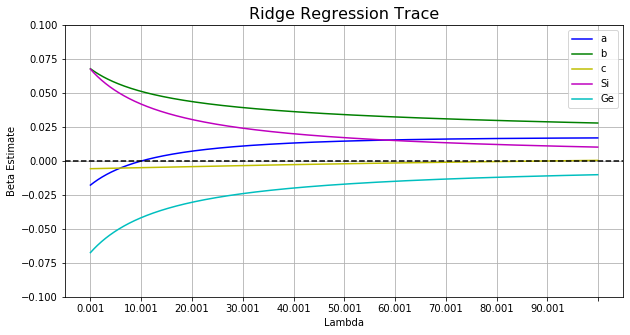

In [10]:
feature_names = band_gap_prediction_objects["Si2Ge3"].band_gap_dataframe_obj.dataframe.keys()[2:]
coef = band_gap_prediction_objects["Si2Ge3"].model_weights 

ridge_df = pd.DataFrame({'variable': feature_names, 'weights': coef})
ridge_train_pred = []
ridge_test_pred = []

X_train = band_gap_prediction_objects["Si2Ge3"].X_train
y_train = band_gap_prediction_objects["Si2Ge3"].y_train
X_test = band_gap_prediction_objects["Si2Ge3"].X_test
y_test = band_gap_prediction_objects["Si2Ge3"].y_test

alphas = np.arange(1e-3,1e2,0.1)

for alpha in alphas:
    ridge_reg = linear_model.Ridge(alpha=alpha)
    ridge_reg.fit(X_train, y_train)
    var_name = str(alpha)
    ridge_df[var_name] = ridge_reg.coef_
    
    # prediction
    ridge_train_pred.append(ridge_reg.predict(X_train))
    ridge_test_pred.append(ridge_reg.predict(X_test))
    
#ridge_df = ridge_df.set_index('variable').T.rename_axis('estimate').rename_axis(None, 1).reset_index()
del ridge_df['weights']
ridge_df = ridge_df.set_index('variable').T

fig, ax = plt.subplots(figsize=(10, 5))
#ax.plot(ridge_df.RM, 'r', ridge_df.ZN, 'g', ridge_df.RAD, 'b', ridge_df.CRIM, 'c', ridge_df.TAX, 'y')
ax.plot(
    ridge_df.a, "b",
    ridge_df.b, "g",
    ridge_df.c, "y",
    ridge_df.Si, "m",
    ridge_df.Ge, "c",
)
ax.axhline(y=0, color='black', linestyle='--')
ax.set_xlabel("Lambda")
ax.set_ylabel("Beta Estimate")
ax.set_title("Ridge Regression Trace", fontsize=16)
ax.legend(labels=["a","b","c","Si","Ge"])
ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
ax.set_ylim(-0.1,0.1)
ax.grid(True)

### SVM 

In [11]:
band_gap_predictions = BandGapPredictions(materials_list,model_type="svm")
band_gap_prediction_objects = band_gap_predictions.band_gap_prediction_objects


Starting prediciton for Si2Ge3 using svm model type...
Material training params: ['a', 'b', 'c', 'alpha', 'beta', 'gamma', 'Si', 'Ge']
Getting Materials Project data ...
Number of Ge-Si system entries in Materials Project: 6
Number of Si entries in Materials Project: 39
Number of Ge entries in Materials Project: 17
Number of results for training: 62


C:\Users\emily\Anaconda3\lib\site-packages\pymatgen\io\cif.py:1123: UserWarning: Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: %s" % "\n".join(self.warnings))


Training the model...
Making predictions...


C:\Users\emily\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


predicted bandgap for  Si2Ge3 : [0.11454508]

Starting prediciton for Si82Ge17 using svm model type...
Material training params: ['a', 'b', 'c', 'alpha', 'beta', 'gamma', 'Si', 'Ge']
Getting Materials Project data ...
Number of Ge-Si system entries in Materials Project: 6
Number of Si entries in Materials Project: 39
Number of Ge entries in Materials Project: 17
Number of results for training: 62


C:\Users\emily\Anaconda3\lib\site-packages\pymatgen\io\cif.py:1123: UserWarning: Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: %s" % "\n".join(self.warnings))


Training the model...
Making predictions...


C:\Users\emily\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


predicted bandgap for  Si82Ge17 : [0.10900411]


### Decision Tree

In [12]:
band_gap_predictions = BandGapPredictions(materials_list,model_type="decision_tree")
band_gap_prediction_objects = band_gap_predictions.band_gap_prediction_objects


Starting prediciton for Si2Ge3 using decision_tree model type...
Material training params: ['a', 'b', 'c', 'alpha', 'beta', 'gamma', 'Si', 'Ge']
Getting Materials Project data ...
Number of Ge-Si system entries in Materials Project: 6
Number of Si entries in Materials Project: 39
Number of Ge entries in Materials Project: 17
Number of results for training: 62


C:\Users\emily\Anaconda3\lib\site-packages\pymatgen\io\cif.py:1123: UserWarning: Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: %s" % "\n".join(self.warnings))


Training the model...
training params= ['a', 'b', 'c', 'alpha', 'beta', 'gamma', 'Si', 'Ge']
Making predictions...
predicted bandgap for  Si2Ge3 : 0.0

Starting prediciton for Si82Ge17 using decision_tree model type...
Material training params: ['a', 'b', 'c', 'alpha', 'beta', 'gamma', 'Si', 'Ge']
Getting Materials Project data ...
Number of Ge-Si system entries in Materials Project: 6
Number of Si entries in Materials Project: 39
Number of Ge entries in Materials Project: 17
Number of results for training: 62


C:\Users\emily\Anaconda3\lib\site-packages\pymatgen\io\cif.py:1123: UserWarning: Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: %s" % "\n".join(self.warnings))


Training the model...
training params= ['a', 'b', 'c', 'alpha', 'beta', 'gamma', 'Si', 'Ge']
Making predictions...
predicted bandgap for  Si82Ge17 : 0.0


### Random Forest

In [13]:
band_gap_predictions = BandGapPredictions(materials_list,model_type="random_forest")
band_gap_prediction_objects = band_gap_predictions.band_gap_prediction_objects


Starting prediciton for Si2Ge3 using random_forest model type...
Material training params: ['a', 'b', 'c', 'alpha', 'beta', 'gamma', 'Si', 'Ge']
Getting Materials Project data ...
Number of Ge-Si system entries in Materials Project: 6
Number of Si entries in Materials Project: 39
Number of Ge entries in Materials Project: 17
Number of results for training: 62


C:\Users\emily\Anaconda3\lib\site-packages\pymatgen\io\cif.py:1123: UserWarning: Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: %s" % "\n".join(self.warnings))


Training the model...
training params= ['a', 'b', 'c', 'alpha', 'beta', 'gamma', 'Si', 'Ge']
Making predictions...
predicted bandgap for  Si2Ge3 : 0.2661349999999999

Starting prediciton for Si82Ge17 using random_forest model type...
Material training params: ['a', 'b', 'c', 'alpha', 'beta', 'gamma', 'Si', 'Ge']
Getting Materials Project data ...
Number of Ge-Si system entries in Materials Project: 6
Number of Si entries in Materials Project: 39
Number of Ge entries in Materials Project: 17
Number of results for training: 62


C:\Users\emily\Anaconda3\lib\site-packages\pymatgen\io\cif.py:1123: UserWarning: Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: %s" % "\n".join(self.warnings))


Training the model...
training params= ['a', 'b', 'c', 'alpha', 'beta', 'gamma', 'Si', 'Ge']
Making predictions...
predicted bandgap for  Si82Ge17 : 0.5573779999999995


In [14]:
for material, band_gap_prediction_object in band_gap_prediction_objects.items():
    x = band_gap_prediction_object.X_train
    y = band_gap_prediction_object.y_train
    band_gap = band_gap_prediction_object.predicted_band_gap
    score = band_gap_prediction_object.model.score(x,y)
    print(f""" 
    {material}
    -----------
    R-squared: {score}
    band gap: {band_gap} eV""")

 
    Si2Ge3
    -----------
    R-squared: 0.8773422239706925
    band gap: 0.2661349999999999 eV
 
    Si82Ge17
    -----------
    R-squared: 0.878043356771643
    band gap: 0.5573779999999995 eV
